In [1]:
from __future__ import division #NOTE: this prevent errors warning GPU0 <> GPU1 (GPU1 has < 75% capacity of GPU0)
import numpy as np
import pickle
import cv2
import imp

import torch as t
import torchvision as tv
import torchvision.transforms as transform
#from torch.utils.data import Dataset, DataLoader

import header_headoren_salcorr as header
import header_saliency_ds as header_sal
imp.reload(header_sal)
imp.reload(header)

from matplotlib import pyplot as plt
%matplotlib inline

use_cuda = t.cuda.is_available()
device = t.device("cuda:0" if use_cuda else "cpu")

H_SAL = 90
W_SAL = 160

del H_SAL
del W_SAL


def modify_fc_layers_obsoleted(model):
    #TODO: change default resnet: avgpool (3, 3), fc (2048 x 3 x 3) --> 90x160
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, H_SAL*W_SAL) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
def modify_fc_layers(model):
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, header_sal.TARGET_SAL_H*header_sal.TARGET_SAL_W) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
    
class PanoSalDataset(t.utils.data.Dataset):
    def __init__(self, pickle_file, transform=None):
        self._pickle_file = pickle_file
        self._dat = pickle.load(open(pickle_file, 'rb'))
    
    def __len__(self):
        return len(self._dat)
    
    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()
        t0, img, smap = self._dat[idx]
        #print (f'Before: {img.shape}')
        img = img.transpose((2, 0, 1))
        #print (f'After: {img.shape}')
        return t0, img, smap
    

In [2]:
#NOTE: this step is only done ONCE to convert pretrained saliency 144x256 to saliency 45x80
#after the converion, the model will be save, this code will be commented out
# PATH = './models/panoresnet152_step002_891'
# resnet = tv.models.resnet152(pretrained=True)
# modify_fc_layers(resnet)
# resnet.load_state_dict(t.load(PATH, map_location=device))
# modify_fc_layers_v2(resnet)
# t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_epoch0')


In [3]:
PATH = '../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_78'
resnet = tv.models.resnet101(pretrained=True)
modify_fc_layers(resnet)
resnet.to(device)
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [4]:
sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_step0.2'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformed_dataset = PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
trainloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


In [5]:
resnet.avgpool, resnet.fc

(AdaptiveAvgPool2d(output_size=3),
 Linear(in_features=18432, out_features=3600, bias=True))

In [6]:
learning_rate = 3e-4
optim = t.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=1e-6)
loss_log = []

In [ ]:
def get_lr(optimizer):#directly change learning rate of the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
import timeit

N_EPOCH = 900
N_REPORT = 200


btime = timeit.default_timer()
for epoch in range(N_EPOCH):
    running_loss = 0.
    for i, (t0, img_list, label_list) in enumerate(trainloader):
        start = t.cuda.Event(enable_timing=True)
        end = t.cuda.Event(enable_timing=True)
        start.record() ###measure training time for one iteration
        img_list = img_list.type(t.FloatTensor).to(device)
        label_list = label_list.type(t.FloatTensor).to(device)
        optim.zero_grad()
        fx = resnet(img_list)
        #print (fx.shape)
        fx = fx.view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
        #loss = t.nn.functional.mse_loss(fx, label_list)
        loss = t.norm(fx - label_list, 2)
        loss.backward()#now backward, grad in graph will have something
        optim.step()#now, the weights is update.
        
        running_loss += loss.item()
        if i % N_REPORT == N_REPORT-1:    # print every N_REPORT mini-batches
            end.record()
            t.cuda.synchronize()
            
            print ('iter time: {}, exec time: {}, cur learning rate: {}'.format(start.elapsed_time(end), timeit.default_timer() - btime, get_lr(optim)))
            btime = timeit.default_timer()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / N_REPORT))
            loss_log.append(running_loss/N_REPORT)
            running_loss = 0.0
            
            
    #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)
    if epoch % 30 ==0 and epoch > 1:
                t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_{}'.format(epoch))
                #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)

iter time: 88.3472671508789, exec time: 18.596662798896432, cur learning rate: 0.0003
[419,   200] loss: 0.539
iter time: 82.92022705078125, exec time: 17.816837524063885, cur learning rate: 0.0003
[419,   400] loss: 0.534
iter time: 90.79948425292969, exec time: 17.35891342582181, cur learning rate: 0.0003
[419,   600] loss: 0.539
iter time: 89.04595184326172, exec time: 18.23922439897433, cur learning rate: 0.0003
[419,   800] loss: 0.533
iter time: 88.95417785644531, exec time: 18.135589748155326, cur learning rate: 0.0003
[419,  1000] loss: 0.527
iter time: 88.48502349853516, exec time: 18.21600564289838, cur learning rate: 0.0003
[419,  1200] loss: 0.539
iter time: 89.27507019042969, exec time: 18.241341105662286, cur learning rate: 0.0003
[419,  1400] loss: 0.534
iter time: 89.1145248413086, exec time: 21.67628023819998, cur learning rate: 0.0003
[420,   200] loss: 0.503
iter time: 90.08678436279297, exec time: 18.27606276422739, cur learning rate: 0.0003
[420,   400] loss: 0.512

In [8]:
#t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_{}'.format(epoch))

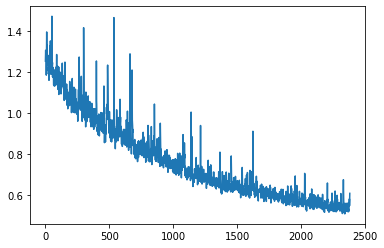

In [9]:
plt.plot(loss_log)

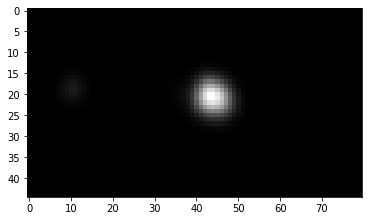

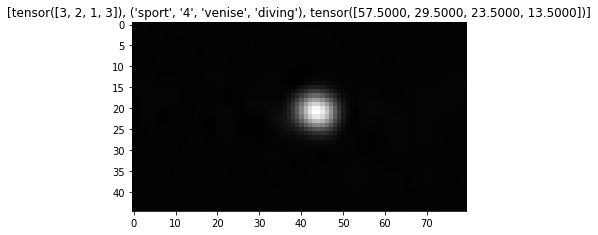

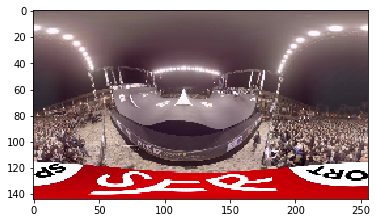

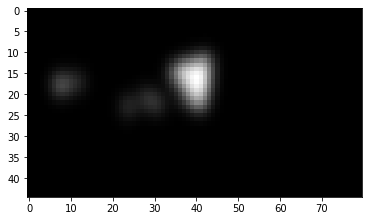

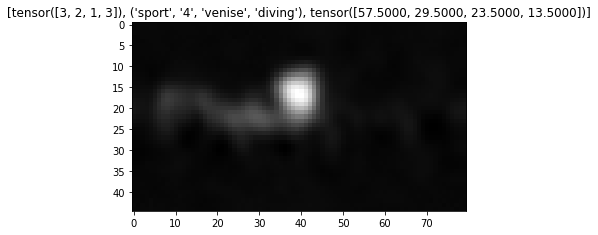

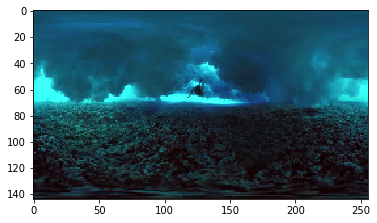

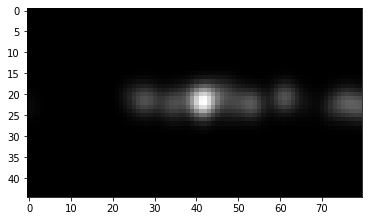

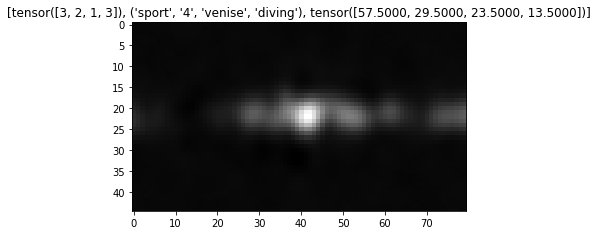

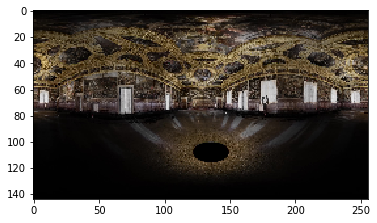

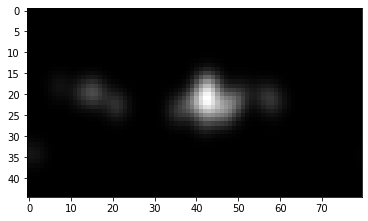

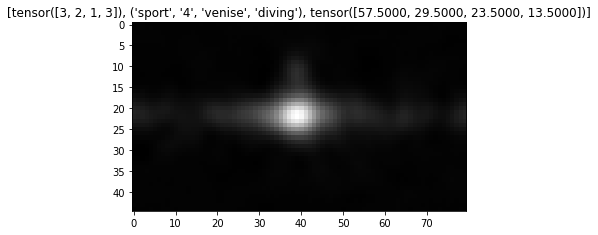

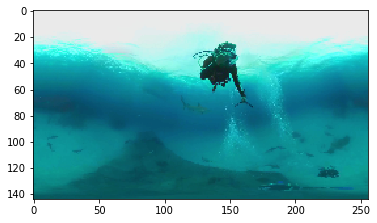

<Figure size 432x288 with 0 Axes>

In [11]:

sal_test_filepath = './data/pano-saliency/ds_dcnn_test'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
test_transformed_dataset = PanoSalDataset(sal_test_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
testloader = t.utils.data.DataLoader(test_transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(4):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.figure()
            plt.imshow(smap, cmap='gray')
            plt.title(t0)
            plt.figure()    
            plt.imshow(img)
            plt.figure()
        break

197


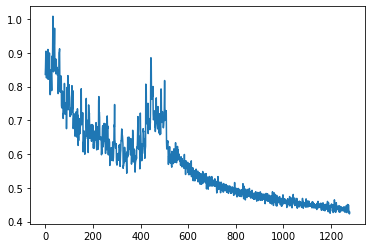

In [57]:
print (epoch)
plt.plot(loss_log[100:])
t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_{}'.format(epoch))

891


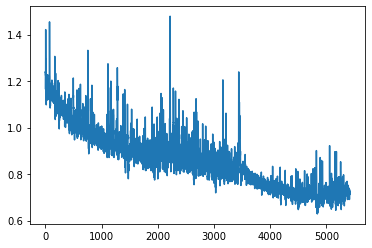

In [20]:
1+1

2

In [41]:
#STEP2: from the model, generate saliency map for all video
#get all timestamp for all saliency_ds{}_topic{}
#generate saliency for given timestamp
#save as named saliency_ds{}_topic_{} in the pano-saliency-predicted folder

In [4]:
#prepare test data to test model
sal_ds_filepath = './dataset/pano-saliency/ds_dcnn_test'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformed_dataset = PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
testloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


In [2]:
#TODO: create saliency data for resnet 101
#load & test model
#PATH = './models/panoresnet152_step003_585'
#PATH = './models/panoresnet101_step005_810'
#PATH = './models/panoresnet152_step002_891'
resnet = tv.models.resnet152(pretrained=True)
modify_fc_layers(resnet)
resnet.to(device)
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [63]:
with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(4):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            #smap = cv2.resize(smap, (header.TARGET_STANDARD_SAL_W, header.TARGET_STANDARD_SAL_H))
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.axis('off')
            plt.figure()
            
            plt.imshow(smap, cmap='gray')
            plt.axis('off')
            plt.figure()

            plt.imshow(img)
            plt.title(t0)
            plt.axis('off')
            plt.figure()
        break

NameError: name 'cv2' is not defined

In [ ]:
#TODO: load the ds_full file, makes all prediction, write back into file

In [28]:
pwd

'/home/anh2/workspace/PanoSaliencyModel'

In [13]:
dat = pickle.load(open('./data/pano-saliency/ds_full', 'rb'))


In [14]:
#TODO: Predict salency for ALL image from ALL videos
#input: file ds_full, containing the groundtruth saliency & the images
#output: a dict containting timestmap & predicted saliency for ALL videos

tdict = header.topic_dict
tf_list = tv.transforms.Compose([tv.transforms.ToTensor(), tf5])
salpred_dict = {1:{}, 2:{}, 3:{}}
with t.no_grad():
    for (ds, topic, t0), img, smap in dat:
            #print (f'creating saliency_ds{ds}_topic{topic}')
            x = tf_list(img).unsqueeze(0).to(device)
            fx = resnet(x)
            fx = fx.data.cpu().view(header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W).numpy()
            #fx = cv2.resize(fx, (header.TARGET_STANDARD_SAL_W, header.TARGET_STANDARD_SAL_H))
            if topic not in salpred_dict[ds]:
                salpred_dict[ds][topic] = []
            salpred_dict[ds][topic].append((t0, -1, fx))
#             plt.imshow(fx.data.cpu().view(H_SAL, W_SAL))
#             plt.figure()
#             plt.imshow(img)
#             plt.title(f'{ds}-{topic}-{t0}')
#             plt.figure()
#             plt.imshow(smap, cmap='gray')
#             plt.figure()


In [15]:
#now, write down the predicted saliency into files
#panoresnet101_step005_810
for ds in tdict:
    for topic in tdict[ds]:
        print (f'Writting predicted saliency for ds:{ds} - topic:{topic} to file')
        filepath_name = f'../hmd-observe-video-prediction/data/pano-saliency-45x80merge-pred101-step002-iter418/saliency_ds{ds}_topic{topic}'
        pickle.dump(salpred_dict[ds][topic], open(filepath_name, 'wb'))

Writting predicted saliency for ds:1 - topic:paris to file
Writting predicted saliency for ds:1 - topic:roller to file
Writting predicted saliency for ds:1 - topic:venise to file
Writting predicted saliency for ds:1 - topic:diving to file
Writting predicted saliency for ds:1 - topic:timelapse to file
Writting predicted saliency for ds:2 - topic:0 to file
Writting predicted saliency for ds:2 - topic:1 to file
Writting predicted saliency for ds:2 - topic:2 to file
Writting predicted saliency for ds:2 - topic:3 to file
Writting predicted saliency for ds:2 - topic:4 to file
Writting predicted saliency for ds:2 - topic:5part1 to file
Writting predicted saliency for ds:2 - topic:6part1 to file
Writting predicted saliency for ds:2 - topic:7 to file
Writting predicted saliency for ds:2 - topic:8 to file
Writting predicted saliency for ds:3 - topic:coaster2 to file
Writting predicted saliency for ds:3 - topic:diving to file
Writting predicted saliency for ds:3 - topic:drive to file
Writting pre

In [54]:
1+1

2